UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc. This dataset could be used on a variety of tasks, e.g., face detection, age estimation, age progression/regression, landmark localization, etc.

The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

[age] is an integer from 0 to 116, indicating the age
[gender] is either 0 (male) or 1 (female)
[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
[date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
%%bash
ls data
# it seems crop_part1 conists of subset of data contained in UTKFace so we won't be using it.

UTKFace
UTKFace.tar.gz


**Constants**

In [5]:
DATA_DIR = "data/UTKFace"
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP

({0: 'male', 1: 'female'},
 {'female': 1, 'male': 0},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'asian': 2, 'black': 1, 'indian': 3, 'others': 4, 'white': 0})

In [6]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [7]:
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))

In [8]:
attributes = list(map(parse_filepath, files))

data/UTKFace/61_1_20170109142408075.jpg.chip.jpg
data/UTKFace/39_1_20170116174525125.jpg.chip.jpg
data/UTKFace/61_1_20170109150557335.jpg.chip.jpg


In [9]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df.head()

,age,gender,race,file
0,28.0,female,white,data/UTKFace/28_1_0_20170116164219746.jpg.chip...
1,24.0,female,white,data/UTKFace/24_1_0_20170117150731090.jpg.chip...
2,82.0,male,white,data/UTKFace/82_0_0_20170111224022146.jpg.chip...
3,24.0,female,black,data/UTKFace/24_1_1_20170113003752421.jpg.chip...
4,26.0,female,indian,data/UTKFace/26_1_3_20170104235148954.jpg.chip...


# Exploratory analysis

In [10]:
df.describe()

,age
count,23705.000000
mean,33.300907
std,19.885708
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


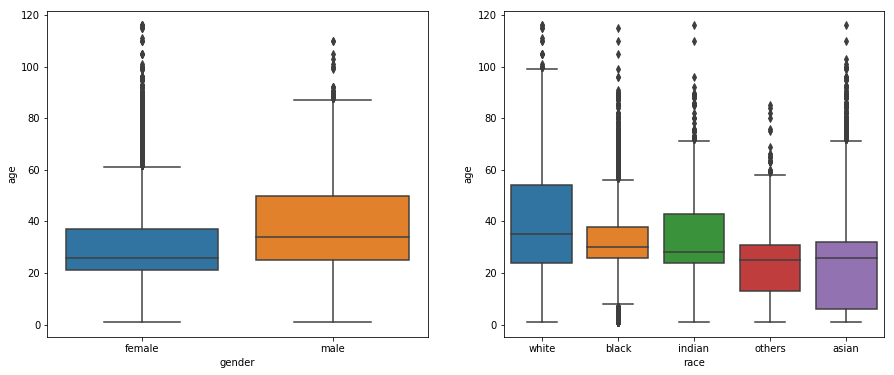

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

From the plot we can see that most of people are within 10 and 55 years of age. Most probably, we'll discard the dataset for rest of the ages.

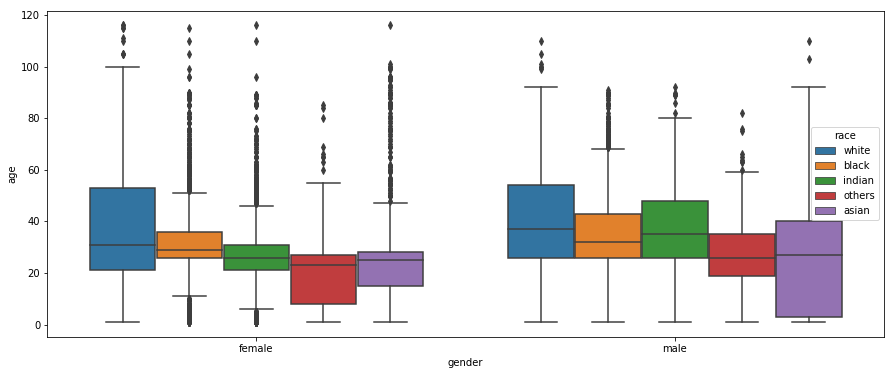

In [12]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='gender', y='age', hue='race')

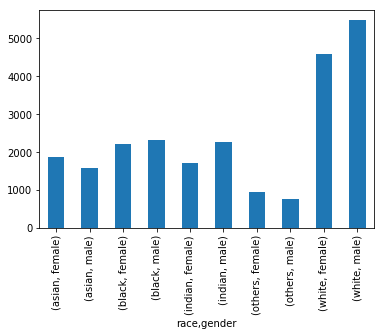

In [13]:
df.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')

It turns out that there are many images of *white male* and *while female*. images from *others* category are very less in number compared to rest of the categories especially *white* category.
Let's analyze our data from *age* perspective.

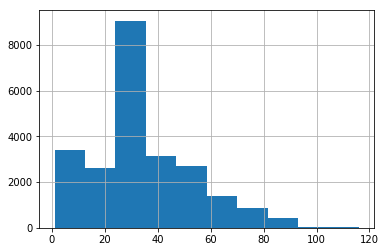

In [14]:
df['age'].hist()

In [15]:
df['age'].describe()

count    23705.000000
mean        33.300907
std         19.885708
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64

In [16]:
df = df[(df['age'] > 10) & (df['age'] < 65)]

# Data prep

In [17]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()
len(train_idx), len(valid_idx), len(test_idx), max_age

(9079, 3891, 5559, 64.0)

In [37]:
from keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            print(file)
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

# Model training

In [21]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout, Flatten
from keras.optimizers import SGD, RMSprop
from keras.models import Model
from keras import applications

vgg_model = applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_shape=(IM_HEIGHT, IM_WIDTH, 3))

x = vgg_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)

# for age calculation
age = Dense(units=128, activation='relu')(x)
age_output = Dense(units=1, activation='sigmoid', name='age_output')(age)

# for race prediction
race = Dense(units=128, activation='relu')(x)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(race)

# for gender prediction
gender = Dense(units=128, activation='relu')(x)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(gender)

model = Model(inputs=vgg_model.input, outputs=[age_output, race_output, gender_output])
opt = RMSprop(lr=1e-5)
model.compile(optimizer=opt, 
              loss={'age_output': 'mse', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 1., 'race_output': 1., 'gender_output': 1.},
              metrics={'age_output': 'mae', 'race_output': 'accuracy', 'gender_output': 'accuracy'})
# model.summary()

W0923 01:44:25.418313 140030473635648 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58900480/58889256 [==============================] - 1s 0us/step


In [23]:
from keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./models/VGG16_clean_model.h5", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=10,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)
                    


Epoch 1/10
141/141 [==============================] - 101s 720ms/step - loss: 0.8922 - age_output_loss: 0.0220 - race_output_loss: 0.6878 - gender_output_loss: 0.1824 - age_output_mae: 0.1170 - race_output_accuracy: 0.7559 - gender_output_accuracy: 0.9345 - val_loss: 0.8793 - val_age_output_loss: 0.0227 - val_race_output_loss: 0.8499 - val_gender_output_loss: 0.1654 - val_age_output_mae: 0.1170 - val_race_output_accuracy: 0.6956 - val_gender_output_accuracy: 0.9432
Epoch 2/10
141/141 [==============================] - 110s 779ms/step - loss: 0.6717 - age_output_loss: 0.0192 - race_output_loss: 0.5233 - gender_output_loss: 0.1292 - age_output_mae: 0.1088 - race_output_accuracy: 0.8175 - gender_output_accuracy: 0.9540 - val_loss: 0.8993 - val_age_output_loss: 0.0218 - val_race_output_loss: 0.6947 - val_gender_output_loss: 0.1564 - val_age_output_mae: 0.1169 - val_race_output_accuracy: 0.7646 - val_gender_output_accuracy: 0.9492
Epoch 3/10
141/141 [==============================] - 110s 7

In [43]:
val = "data/UTKFace/26_0_4_20170117153355923.jpg.chip.jpg"
"/".join([val.split("/")[0], 'adv', val.split("/")[2]])

'data/adv/26_0_4_20170117153355923.jpg.chip.jpg'

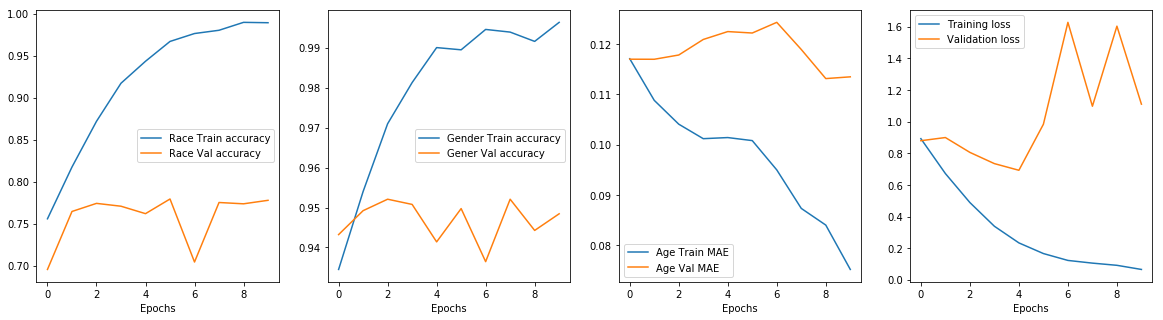

In [27]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['age_output_mae'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_mae'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

In [28]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

{'age_output_loss': 0.02103092148900032,
 'age_output_mae': 0.11278758943080902,
 'gender_output_accuracy': 0.9491279125213623,
 'gender_output_loss': 0.20088206231594086,
 'loss': 0.9300190210342407,
 'race_output_accuracy': 0.7977834343910217,
 'race_output_loss': 0.8107038140296936}

In [29]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, (age_true, race_true, gender_true)= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)

In [30]:
race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)
age_true = age_true * max_age
age_pred = age_pred * max_age

In [31]:
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))


ImportError: No module named sklearn.metrics

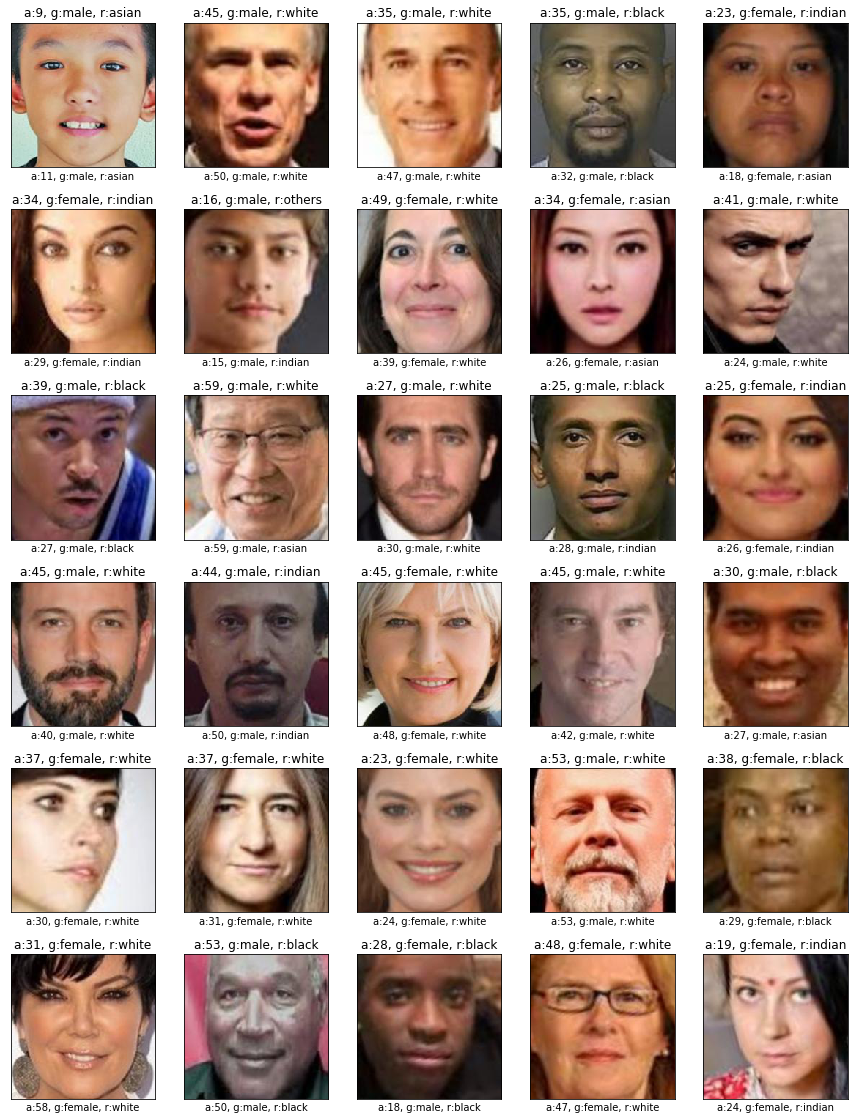

In [33]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = int(math.ceil(n / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('a:{}, g:{}, r:{}'.format(int(age_pred[img_idx]), ID_GENDER_MAP[gender_pred[img_idx]], ID_RACE_MAP[race_pred[img_idx]]))
    ax.set_xlabel('a:{}, g:{}, r:{}'.format(int(age_true[img_idx]), ID_GENDER_MAP[gender_true[img_idx]], ID_RACE_MAP[race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])
    

# Training of a separate model with gradient ascent on Race

In [34]:
vgg_adv_model = applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_shape=(IM_HEIGHT, IM_WIDTH, 3))

x = vgg_adv_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)

# for age calculation
age = Dense(units=128, activation='relu')(x)
age_output = Dense(units=1, activation='sigmoid', name='age_output')(age)

# for race prediction
race = Dense(units=128, activation='relu')(x)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(race)

# for gender prediction
gender = Dense(units=128, activation='relu')(x)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(gender)

model = Model(inputs=vgg_adv_model.input, outputs=[age_output, race_output, gender_output])
opt = RMSprop(lr=1e-5)
model.compile(optimizer=opt, 
              loss={'age_output': 'mse', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 1., 'race_output': -1., 'gender_output': 1.},
              metrics={'age_output': 'mae', 'race_output': 'accuracy', 'gender_output': 'accuracy'})
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 198, 198, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 198, 198, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 198, 198, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 99, 99, 64)   0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [35]:
from keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./models/VGG16_adv_model.h5", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=10,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)
                    


Epoch 1/10
141/141 [==============================] - 102s 724ms/step - loss: -3081072757.0192 - age_output_loss: 0.2979 - race_output_loss: 3083452672.0000 - gender_output_loss: 2379861.0000 - age_output_mae: 0.5054 - race_output_accuracy: 0.1801 - gender_output_accuracy: 0.5141 - val_loss: -32188917760.0000 - val_age_output_loss: 0.3191 - val_race_output_loss: 32410605568.0000 - val_gender_output_loss: 33327550.0000 - val_age_output_mae: 0.5312 - val_race_output_accuracy: 0.1901 - val_gender_output_accuracy: 0.4797
Epoch 2/10
141/141 [==============================] - 105s 743ms/step - loss: -6214450766884.3115 - age_output_loss: 0.3176 - race_output_loss: 6217200041984.0000 - gender_output_loss: 2749470976.0000 - age_output_mae: 0.5298 - race_output_accuracy: 0.1797 - gender_output_accuracy: 0.5093 - val_loss: -33098381131776.0000 - val_age_output_loss: 0.3193 - val_race_output_loss: 36790249455616.0000 - val_gender_output_loss: 19388647424.0000 - val_age_output_mae: 0.5314 - val_ra

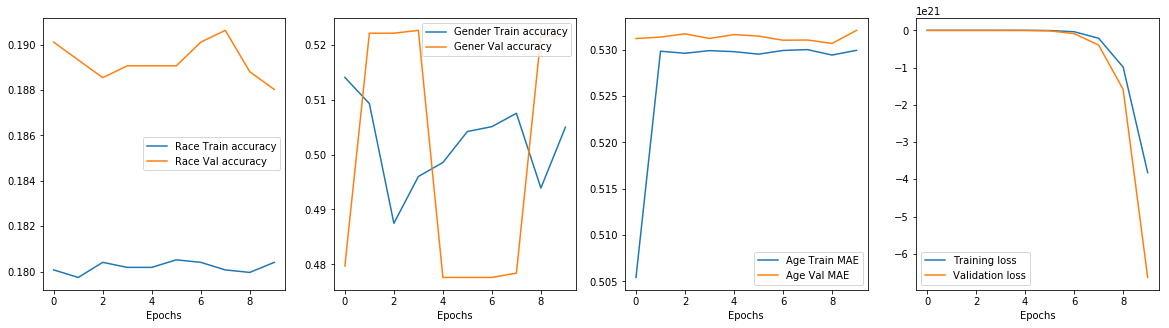

In [36]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['age_output_mae'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_mae'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)